# Using Fully Connected  NN to Make Predictions

In [3]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Preprocessing Plan:
* Use Functional API
* Treat the categorical and numerical features differently.
    * One-hot: Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days
    * Embed  : Day_Index, curr_month_1_delta, curr_month_15_delta, next_month_1_delta
    * Numerical (normalized): Rest
    * Sources for Functional API:
        * [How to slice an input in keras?](https://datascience.stackexchange.com/questions/86740/how-to-slice-an-input-in-keras)
        * [Sequential API vs Functional API model in Keras](https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e)
    

### Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days
No change, use directly as one-hot

In [4]:
one_hots = layers.Input(shape=[6])

### Day_Index, next_month_1_delta
* [CategoryEncoding](https://keras.io/api/layers/preprocessing_layers/categorical/category_encoding/): Convert to one hot formation
* [Embedding](https://keras.io/api/layers/core_layers/embedding/): Embed the sparse index vector to dense index

In [5]:
day_index_feature  = layers.Input(shape=[1])
day_index_embedded = layers.Embedding(input_dim=7, output_dim=10)(day_index_feature)

delta_feature  = layers.Input(shape=[1])
delta_embedded = layers.Embedding(input_dim=31, output_dim=50)(delta_feature)

embeddeds = layers.Concatenate()([day_index_embedded, delta_embedded])
embeddeds_flat = layers.Flatten()(embeddeds)


### Numericals
* [BatchNormalization layer](https://keras.io/api/layers/normalization_layers/batch_normalization/): Normalize each feature. Features are last values, trend and averages of CashIn and CashOut.


In [6]:
features_to_normalize = layers.Input(shape=[60])
normalized            = layers.BatchNormalization()(features_to_normalize)

### Concatenating All Paths Together

In [7]:
preprocessed = layers.Concatenate()([one_hots, embeddeds_flat, normalized])

Draw the model so far:

In [8]:
preprocessing_model = keras.Model(inputs=[one_hots, day_index_feature, delta_feature, features_to_normalize], outputs=[preprocessed] )
#from tensorflow.keras.utils import plot_model
#plot_model(preprocessing_model, show_shapes=True, show_layer_names=True)
preprocessing_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        70          input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1550        input_3[0][0]                    
_______________________________________________________________________________________

## Rest of The Model

In [9]:
dense1 = layers.Dense(128, activation='relu')(preprocessed)
dense2 = layers.Dense(32, activation='relu')(dense1)
dense3 = layers.Dense(16, activation='relu')(dense2)
nn_output = layers.Dense(1)(dense3)

In [10]:
nn_model = keras.Model(inputs=[one_hots, day_index_feature, delta_feature, features_to_normalize], outputs=[nn_output] )
nn_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        70          input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1550        input_3[0][0]                    
_______________________________________________________________________________________

In [11]:
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mape')

## Arranging Data

In [12]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

In [13]:
feature_set.columns

Index(['CashIn', 'CashOut', 'Day_Index', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Is_Weekday', 'Is_Weekend',
       'CashIn_average_7', 'CashIn_average_30', 'CashOut_average_7',
       'CashOut_average_30', 'curr_month_1_delta', 'curr_month_15_delta',
       'next_month_1_delta', 'CashIn_trend_7', 'CashOut_trend_7', 'is_ramazan',
       'ramazan_in_7_days', 'is_kurban', 'kurban_in_7_days', 'CashIn_t-1',
       'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
       'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
       'CashIn_t-12', 'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1',
       'CashOut_t-2', 'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5',
       'CashOut_t-6', 'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9',
       'CashOut_t-10', 'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13',
       'CashOut_t-14', 'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17',
       'CashOut_t-18', 'CashOut_t-19', 'CashOut_t-20', 'CashOut_

In [14]:
def get_input_sets(df):
    one_hot_features    = df['Is_Weekday, Is_Weekend, is_ramazan, ramazan_in_7_days, is_kurban, kurban_in_7_days'.split(', ')].astype('float32')
    day_index           = df['Day_Index']
    delta               = df['next_month_1_delta'] - 1
    normalized_features = df[['CashIn_trend_7', 'CashOut_trend_7', 'CashIn_t-1',
    'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
    'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
    'CashIn_t-12', 'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1',
    'CashOut_t-2', 'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5',
    'CashOut_t-6', 'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9',
    'CashOut_t-10', 'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13',
    'CashOut_t-14', 'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17',
    'CashOut_t-18', 'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21',
    'CashOut_t-22', 'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25',
    'CashOut_t-26', 'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29',
    'CashOut_t-30', 'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33',
    'CashOut_t-34', 'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37',
    'CashOut_t-38', 'CashOut_t-39', 'CashOut_t-40', 'CashIn_average_7',
    'CashIn_average_30', 'CashOut_average_7', 'CashOut_average_30']].astype('float32')

    return [one_hot_features, day_index, delta, normalized_features]

In [15]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(feature_set[feature_set.columns[2:]], feature_set[TARGET], shuffle = False)

In [16]:
train_inputs = get_input_sets(X_train)
test_inputs  = get_input_sets(X_test)

## Training

In [17]:
history = nn_model.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=100,
            validation_data=(test_inputs, y_test),
            verbose = 1)

Epoch 1/100
34/34 [==============================] - 0s 8ms/step - loss: 97.6453 - val_loss: 56.9507
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 58.9019 - val_loss: 42.1799
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 47.3494 - val_loss: 55.2206
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 43.8033 - val_loss: 39.4901
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 42.3096 - val_loss: 37.2803
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 41.1456 - val_loss: 45.8347
Epoch 7/100
34/34 [==============================] - 0s 1ms/step - loss: 40.1162 - val_loss: 44.5985
Epoch 8/100
34/34 [==============================] - 0s 1ms/step - loss: 41.5863 - val_loss: 38.3522
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 39.8833 - val_loss: 38.9869
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 39.9054 - val_los

In [18]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key], label = key)
    plt.legend()
    plt.show()

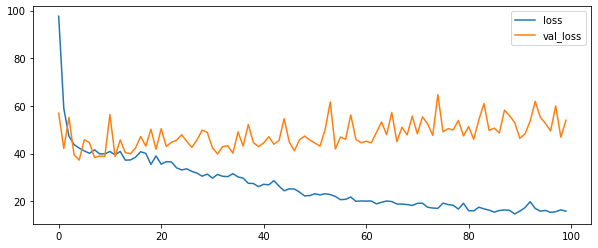

In [19]:
plot_history(history)

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| Custom RNN | - | - | 70.7 |
| TF-Fully Connected | 15.1 | 40.3 | - |


In [20]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [29]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)

In [30]:
draw_model_error(nn_model, get_input_sets(feature_set[feature_set.columns[2:]]), feature_set[TARGET])